In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle
import matplotlib

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import ops_plotall, ops_plotsubset, ops_plot_acp_inits, ops_plot_timing_inits
import scipy

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'
fs_=8
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.titlesize"] = fs_
plt.rcParams["axes.labelsize"] = fs_
matplotlib.rc('xtick', labelsize=fs_) 
matplotlib.rc('ytick', labelsize=fs_) 
plt.rc('legend',fontsize=fs_)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
wc = WCModel()
wc.params.sigma_ou = 0.

dt = 0.1
wc.params.dt = dt

duration = 80.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)

wc.params["duration"] = duration
x_init = 0.045135938287846025
y_init = 0.08586538415443892
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

wc.run()
peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
p_list = []
for i in range(3,len(peaks)):
    p_list.append(peaks[i]- peaks[i-1])
period = np.mean(p_list)*dt

savepath = ('..' + os.sep + '..' + os.sep + '..' + os.sep + '..' + os.sep + '..' + os.sep + 'writing' + os.sep +
                'paper2_chaos' + os.sep + 'exploration' + os.sep + 'images_ops' + os.sep + 'sc0' + os.sep )

savepath_subset = ( '..' + os.sep + '..' + os.sep + '..' + os.sep + '..' + os.sep + '..' + os.sep + 'writing' + os.sep +
                        'paper2_chaos' + os.sep + 'opt_phase_shift' + os.sep + 'images' + os.sep + 'sc0' + os.sep )

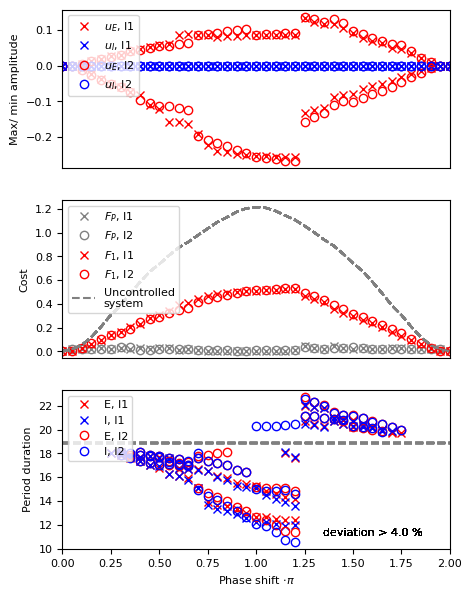

In [24]:
filehandler = open("results_min_w1.pickle","rb")
results_min_w1 = pickle.load(filehandler)
filehandler.close()

filehandler = open("results_peak_w1.pickle","rb")
results_peak_w1 = pickle.load(filehandler)
filehandler.close()

for i_w in range(len(results_min_w1["w1"])):
    break
    ops_plotall(results_min_w1["control"][i_w], 0.25, duration, dt, 40., results_min_w1["filename"][i_w], savepath)
    #ops_plotsubset(results_min_w1["state"][i_w], results_min_w1["control"][i_w], 0.4, 0.1, duration, dt, 40., 
    #            results_min_w1["filename"][i_w], savepath_subset)
    ops_plotall(results_peak_w1["control"][i_w], 0.25, duration, dt, 40., results_peak_w1["filename"][i_w], savepath)
    #ops_plotsubset(results_peak_w1["state"][i_w], results_peak_w1["control"][i_w], 0.4, 0.1, duration, dt, 40., 
    #            results_peak_w1["filename"][i_w], savepath_subset)

ops_plot_acp_inits(results_min_w1, results_peak_w1, period, 0.04, dt, "plot1", savepath)
ops_plot_timing_inits(results_min_w1, results_peak_w1, dt, [0,80], 20., "plot2", savepath)

In [29]:
wc = WCModel()
wc.params.sigma_ou = 0.

dt = 0.01
wc.params.dt = dt

duration = 300.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
input = zero_control.copy()

wc.params["duration"] = duration
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

wc.run()
de = 10.

peaks0 = scipy.signal.find_peaks(wc.exc[0,:])[0]
p_list = []
for i in range(3,len(peaks0)):
    p_list.append(peaks0[i]- peaks0[i-1])
period = np.mean(p_list)*dt

i0, i1 = 0, 0
for i in range(len(peaks0)):
    if peaks0[i] > 100/dt:
        i0 = peaks0[i]
        i1 = peaks0[i+1]
        break

ind_range = range(i0, i1+1,1)
shift_ep = np.zeros((len(ind_range)))
shift_em = np.zeros((len(ind_range)))
shift_ip = np.zeros((len(ind_range)))
shift_im = np.zeros((len(ind_range)))
shift_epim = np.zeros((len(ind_range)))
shift_emip = np.zeros((len(ind_range)))

for i in range(len(ind_range)):
    t = ind_range[i]

    wc.params.exc_ext[0,t] += de
    wc.params.inh_ext[0,t] += -de
    wc.run()
    wc.params.exc_ext[0,t] -= de
    wc.params.inh_ext[0,t] -= -de

    peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
    shift_epim[i] = (peaks[-1] - peaks0[-1])*dt

    wc.params.exc_ext[0,t] += -de
    wc.params.inh_ext[0,t] += de
    wc.run()
    wc.params.exc_ext[0,t] -= -de
    wc.params.inh_ext[0,t] -= de

    peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
    shift_emip[i] = (peaks[-1] - peaks0[-1])*dt

    wc.params.exc_ext[0,t] += de
    wc.run()
    wc.params.exc_ext[0,t] -= de

    peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
    shift_ep[i] = (peaks[-1] - peaks0[-1])*dt

    wc.params.exc_ext[0,t] += -de
    wc.run()
    wc.params.exc_ext[0,t] -= -de

    peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
    shift_em[i] = (peaks[-1] - peaks0[-1])*dt

    wc.params.inh_ext[0,t] += de
    wc.run()
    wc.params.inh_ext[0,t] -= de

    peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
    shift_ip[i] = (peaks[-1] - peaks0[-1])*dt

    wc.params.inh_ext[0,t] += -de
    wc.run()
    wc.params.inh_ext[0,t] -= -de

    peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
    shift_im[i] = (peaks[-1] - peaks0[-1])*dt

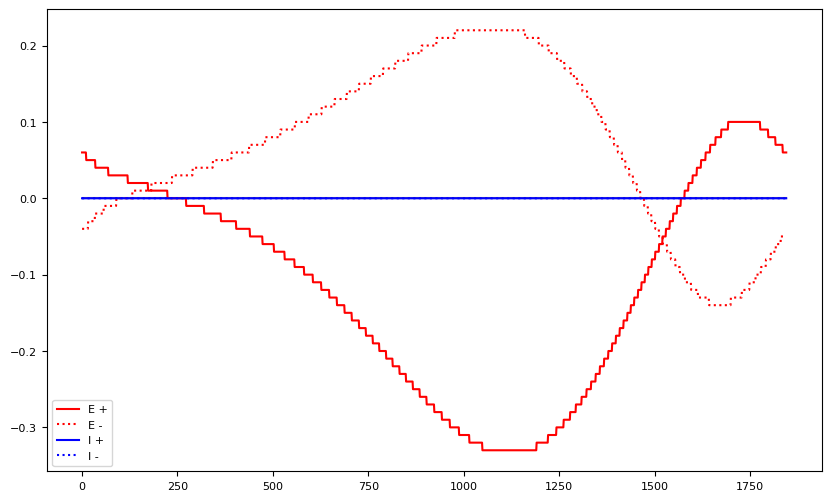

In [ ]:
phase = np.linspace(0,2*np.pi, len(ind_range))
plt.plot(phase, shift_ep, color="red", label="E +")
plt.plot(phase, shift_em, color="red", label="E -", linestyle=':')
plt.plot(phase, shift_ip, color="blue", label="I +")
plt.plot(phase, shift_im, color="blue", label="I -", linestyle=':')

plt.hlines(0., 0,len(ind_range), color="grey")
plt.legend(loc="lower left")
plt.show()